# Clustering

In [22]:
from typing import List, Type, Union

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import fetch_openml
from sklearn.base import ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MeanShift, DBSCAN, AgglomerativeClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram

## Zbiór danych

W zadaniu poddany analizie będzie zbiór MNIST.

In [2]:
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

In [3]:
X = mnist.data[:2000]
y = mnist.target[:2000]

In [4]:
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

pca = PCA(30)
X_pca = pca.fit_transform(X_scaled)

In [5]:
X_embedded = TSNE(n_components=2).fit_transform(X_pca)
X_embedded.shape

(2000, 2)

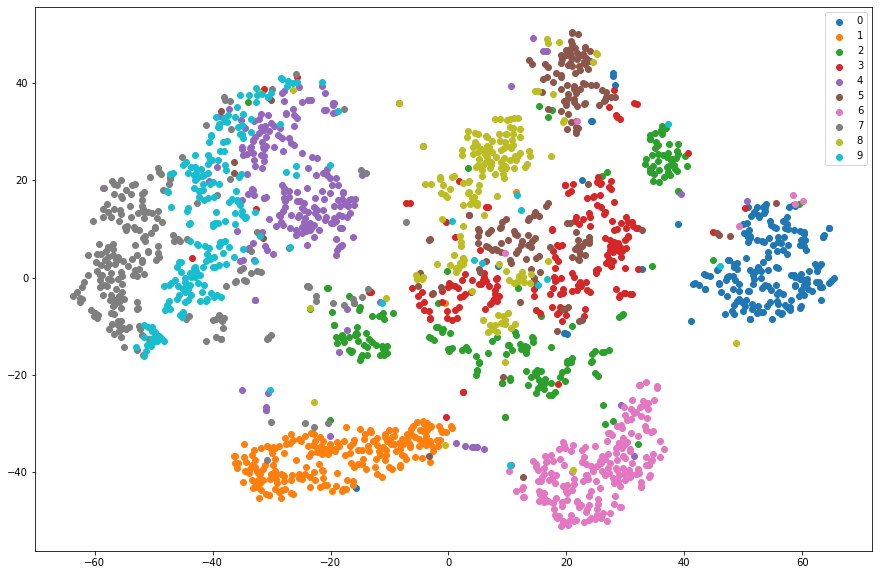

In [6]:
ids = [str(i) for i in range(10)]
plt.figure(figsize=(15, 10))

for c, label in zip(mcolors.TABLEAU_COLORS, ids):
    plt.scatter(X_embedded[y == label, 0], X_embedded[y == label, 1], c=c, label=label)
plt.legend()
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=13)
X_train.shape

(1600, 30)

### K-Means
Spróbujmy zaprezentować obliczone centra przez k-means dla zredukowanego do przestrzeni dwuwymiarowej zbioru MINST

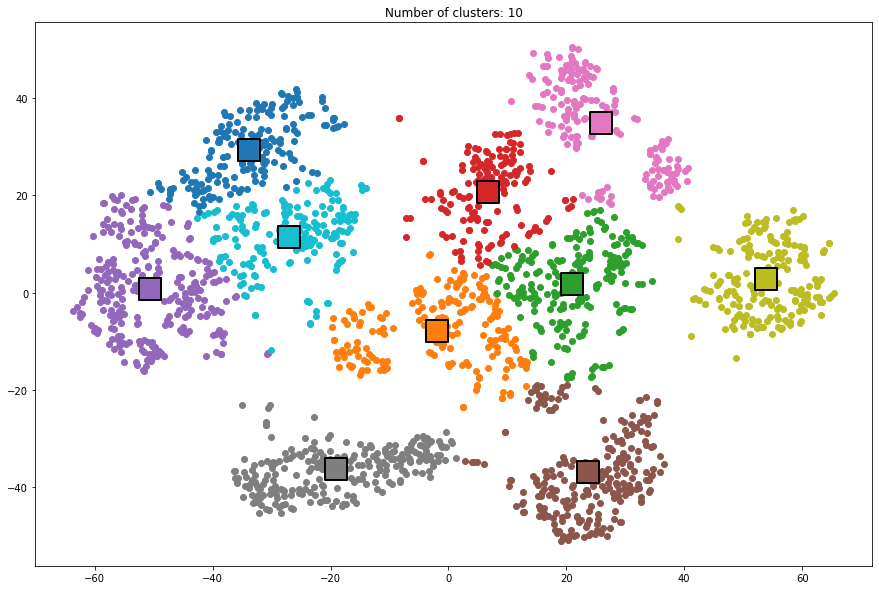

In [8]:
plt.figure(figsize=(15, 10))

km = KMeans(
    n_clusters=10,
).fit(X_embedded, y)

labels = km.labels_
cluster_centers = km.cluster_centers_
n_clusters_ = len(np.unique(labels))

for k, col in zip(range(n_clusters_), mcolors.TABLEAU_COLORS):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.scatter(X_embedded[my_members, 0], X_embedded[my_members, 1], c=col)
    plt.scatter(cluster_center[0], cluster_center[1], marker='s', c=col, s=500, edgecolors='black', linewidth='2')
plt.title('Number of clusters: %d' % n_clusters_)
plt.show()

Nie wiemy które centrum odpowiada jakiej liczbie TODO

### MeanShift

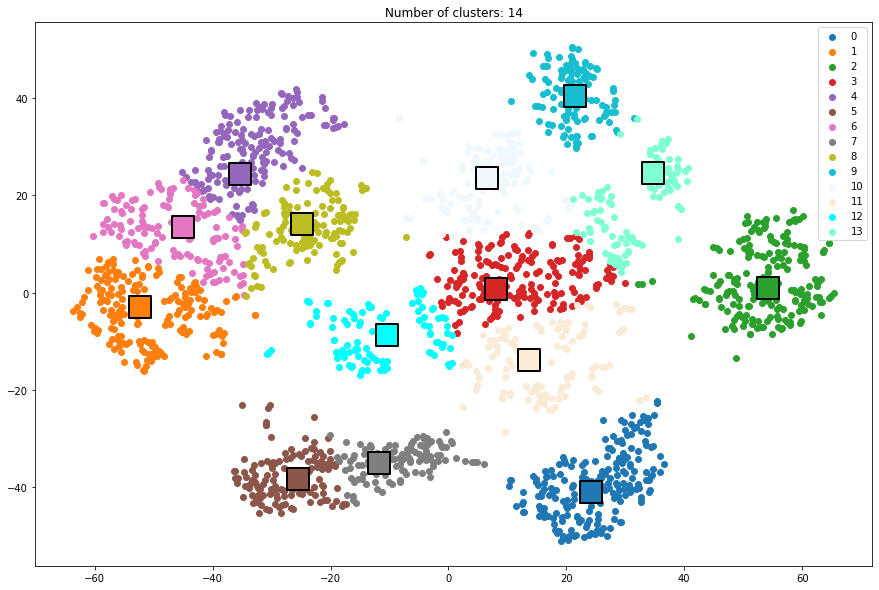

In [10]:
bandwidth = estimate_bandwidth(X_embedded, quantile=0.05)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(X_embedded)

plt.figure(figsize=(15, 10))

labels = ms.labels_
cluster_centers = ms.cluster_centers_
n_clusters_ = len(np.unique(labels))

colors = dict(mcolors.TABLEAU_COLORS, **mcolors.CSS4_COLORS)

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.scatter(X_embedded[my_members, 0], X_embedded[my_members, 1], c=col, label=k)
    plt.scatter(cluster_center[0], cluster_center[1], marker='s', c=col, s=500, edgecolors='black', linewidth='2')
plt.title('Number of clusters: %d' % n_clusters_)
plt.legend()
plt.show()

### DBSCAN
Ten rodzaj clusteringu nie przewiduje obliczanych centrów, jednak wyróżnia punkty Noise (oznaczane na czarno) oraz punkty brzegowe (z czarnym obramowaniem)

Estimated number of noise points: 68


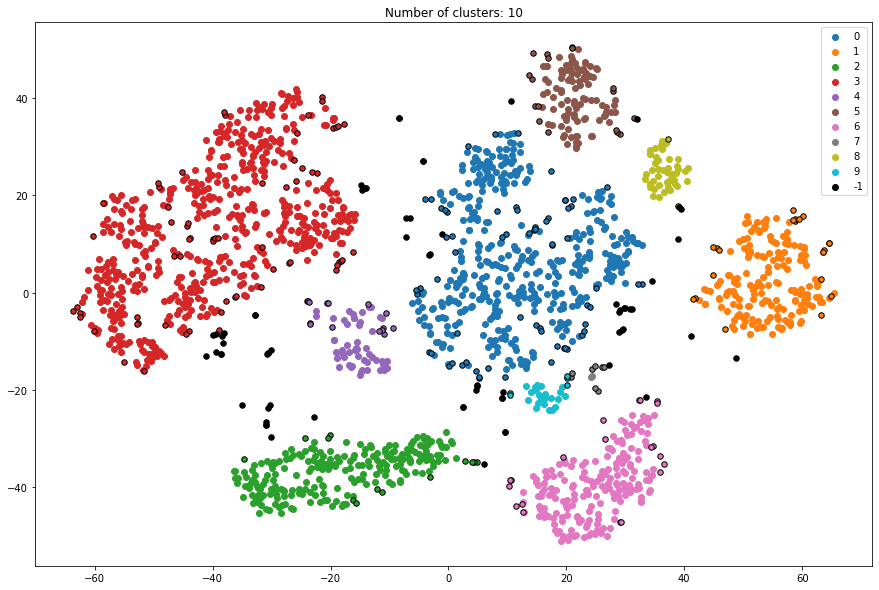

In [11]:
db = DBSCAN(eps=3.7, min_samples=10).fit(X_embedded)

plt.figure(figsize=(15, 10))

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of noise points: %d' % n_noise_)

unique_labels = set(labels)

colors = dict(mcolors.TABLEAU_COLORS, **mcolors.CSS4_COLORS)

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'black'
    
    class_member_mask = (labels == k)
    xy = X_embedded[class_member_mask & core_samples_mask]

    plt.scatter(xy[:, 0], xy[:, 1], c=col, label=k)
    
    xy = X_embedded[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=col, s=30, edgecolors='black', linewidth='1')
    
plt.title('Number of clusters: %d' % n_clusters_)
plt.legend()
plt.show()

### Agglomerative Hierarchical Clustering

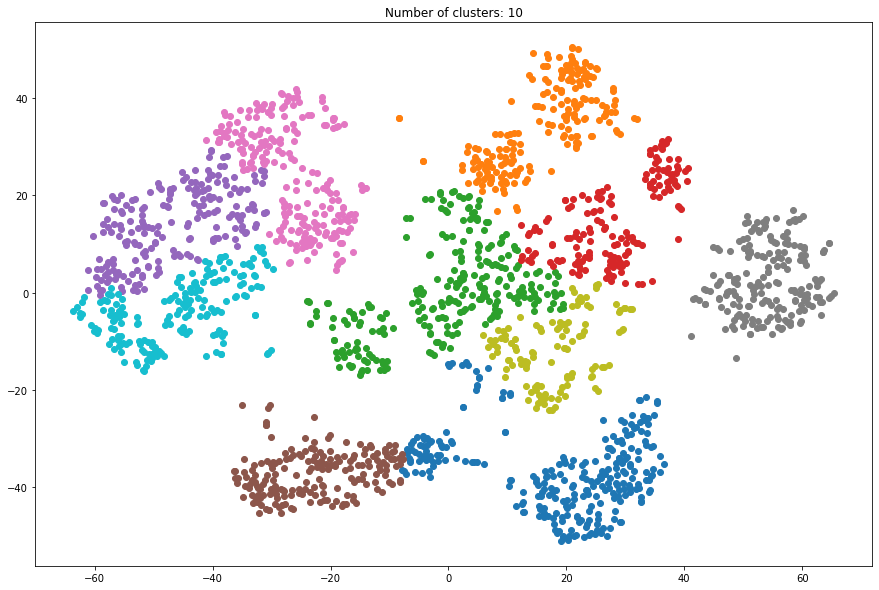

In [12]:
plt.figure(figsize=(15, 10))

linkage = ["ward", "complete", "average", "single"]

agg = AgglomerativeClustering(
    n_clusters=10,linkage=linkage[1]
).fit(X_embedded)

labels = agg.labels_
n_clusters_ = len(np.unique(labels))

for k, col in zip(range(n_clusters_), mcolors.TABLEAU_COLORS):
    my_members = labels == k
    plt.scatter(X_embedded[my_members, 0], X_embedded[my_members, 1], c=col)
plt.title('Number of clusters: %d' % n_clusters_)
plt.show()

Możliwe jest wyświetlenie hierarchii, przy czym zmniejszymy zbiór dla większej szybkości wykonania obliczeń

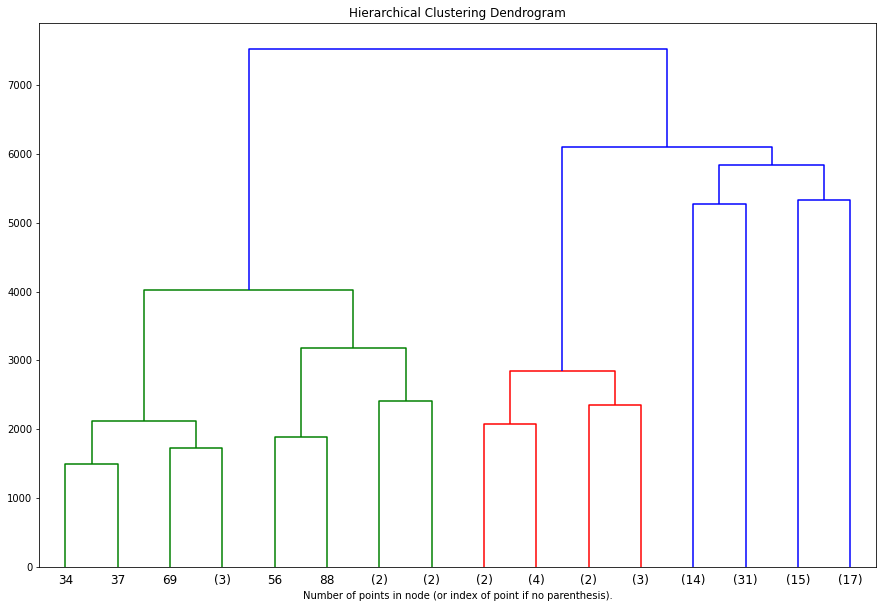

In [13]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

test_size = 100
X_small = mnist.data[:test_size]

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X_small)

plt.figure(figsize=(15, 10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### GaussianMixture

[9 4 6 ... 3 3 4]


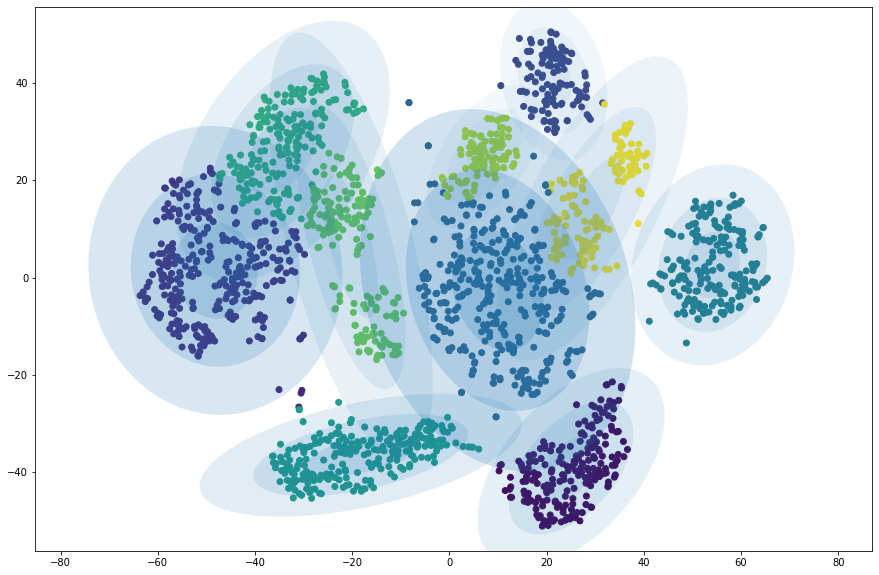

In [45]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, **kwargs):
    ax = plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X):
    ax = plt.gca()
    labels = gmm.fit(X).predict(X)
    print(labels)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
    else:
        ax.scatter(X[:, 0], X[:, 1])
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

plt.figure(figsize=(15, 10))

gmm = GaussianMixture(n_components=10, covariance_type='full').fit(X_embedded)

plot_gmm(gmm, X_embedded)